In [1]:
# ME EN 4650  Lab9:Flat Plate Convection   Ryan Dalby    
import numpy as np
from numpy import random
from numpy.lib.function_base import kaiser
from numpy.lib.twodim_base import tril_indices_from
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from pandas.plotting import table
import os
import matlab.engine # Must install from matlab installation direcotry using: cd "matlabroot\extern\engines\python" && python setup.py install 


In [2]:
# Define useful functions
mmhg_to_pa = lambda mmhg : mmhg*133.3 # Lambda function to covert mmHg to Pa
inh2o_to_pa = lambda inh2o : inh2o*249.04 # Lambda function to covert inH20 to Pa
in_to_m = lambda inch : inch*0.0254 # Lambda function to convert in to m
cm_to_m = lambda cm : cm/100 # Lambda function to convert cm to m
mm_to_m = lambda mm : mm/1000 # Lambda function to convert mm to m
degCToK = lambda degC : degC+273.15 # Lambda function to covert degC to K

# Define vairables
# Experimental geomertry
zeta = mm_to_m(77) # Entrance length in m
Lh = mm_to_m(153) # Heated section length in m
L = zeta + Lh # Length up to end of heated section in m
w = mm_to_m(68) # Width of heated section in m

# from Propertie-3.txt file:
Tamb = 21 # Ambient temperature for experiment deg C
Patm = mmhg_to_pa(660) # Atmospheric pressure for experiment in Pa
Pdyn = mmhg_to_pa(0.083) # Dynamic pressure for experiment in Pa 
V = 36.34 # Heater supply voltage in V (AC)
R = 157.7 # Heater supply resistance in Ohms 
fan_speed = 12 # Fan speed in Hz

# Experimental temperature readings
Ts_filename = 'T_final.txt'
Tinf_filename = 'Tambient-3.txt'
Ts = pd.read_csv(Ts_filename, sep='\t') # Surface temperature readings
Tinf = pd.read_csv(Tinf_filename, sep='\t')
Tinf_avg = np.mean(Tinf.iloc[:,1]) # Average freestream temperature in deg C

# Thermocouple locations (1-16 respectively)
x_thermloc = np.array([85,92,102,112,123,123,134,143,153,162,173,173,186,196,209,219]) # Thermocouple locations in mm
x_thermloc = mm_to_m(x_thermloc)


In [3]:
# AirPropeties.m wrapper for python
# Given temperature in K and atmospheric pressure in Pa will give rho in kg/m**3, mu in kg/(m*s), k in W/(m*K), and Cp in J/(kg*K)
def AirProperties_wrapper(T,P):
    eng = matlab.engine.start_matlab()
    eng.addpath(os.path.abspath(os.getcwd()))
    rho =[]
    mu = []
    k = []
    cp = []
    if(not isinstance(T,np.ndarray)):
        T = np.array([T])
    if(not isinstance(P,np.ndarray)):
        if(np.size(T) != np.size(P)):
            P = np.full(np.size(T),P)
        else: 
            P = np.array([P]) 
    for i in range(np.size(T)):
        matlab_output = eng.AirProperties(float(T[i]),float(P[i]),nargout=4)
        rho.append(matlab_output[0])
        mu.append(matlab_output[1])
        k.append(matlab_output[2])
        cp.append(matlab_output[3])
    eng.quit()
    return (np.array(rho), np.array(mu), np.array(k), np.array(cp))


In [4]:
# Data analysis 
Ts_top = Ts.drop([5,11]).iloc[:,1].to_numpy()
Ts_bottom = Ts.iloc[[5,11],1].to_numpy()
x_thermloc_top = np.delete(x_thermloc, [5,11])
qs_primeprime_conv = V**2/(2*R*Lh*w) # Net heat flux on top surface in W/m**2 from resistive heating with no other losses
hx = qs_primeprime_conv/(Ts_top-Tinf_avg) # Local heat transfer coefficient in W/(m**2*K)
Lt = x_thermloc[-1]-x_thermloc[0]# Integration length for average heat transfer coefficient
hL_bar = (1/Lt) * np.trapz(hx, x_thermloc_top) # Average heat transfer coefficient over the heated part of plate in W/(m**2*K)
Tf = (Ts_top+Tinf_avg)/2 # Local film temperature in deg C
Tf_bar = np.mean(Tf) # Average film temperature over the whole plate in deg C
kf = AirProperties_wrapper(degCToK(Tf),Patm)[2] # Local thermal conductivity in W/(m*K)
air_exp_properties = AirProperties_wrapper(degCToK(Tf_bar),Patm)
kf_bar = air_exp_properties[2][0] # Thermal conductivity for the average film temperature over the whole plate
Nu_x = (hx*x_thermloc_top)/kf
Nu_L_bar = (hL_bar*L)/kf_bar
qs = (w*L) * qs_primeprime_conv


In [5]:
# Theoretical Predictions
nu_air = 1.85e-5 # Kinematic viscosity for Salt Lake city, Utah in m**2/s 
rho_air = air_exp_properties[0][0] # Density of air in kg/m**3
Uinf = np.sqrt(2*Pdyn/rho_air) # Feestream air speed in m/s
k_air = air_exp_properties[2][0] # k of airin W/(m*K)
cp_air = air_exp_properties[3][0] # Cp of air in J/(kg*K)
alpha = (k_air/(cp_air*rho_air))
Pr = nu_air/alpha
x_ther = np.linspace(zeta,L,100)
Re_c = 5e5 # Critical Reynolds number for flat plate
hx_ther = []
Nu_x_ther = []
for i in range(np.size(x_ther)):
    x = x_ther[i]
    Re = Uinf*x/nu_air
    Nu = 0 # Default value
    if(Re < Re_c): # Laminar
        Nu = (0.453*(Re**0.5)*(Pr**(1/3)))/((1-(zeta/x)**(3/4))**(1/3))
    else: # Turbulent
        Nu = (0.031*Re**(4/5)*Pr**(1/3))/((1-(zeta/x)**(9/10))**(1/9))
    h = (k_air/x)*Nu
    Nu_x_ther.append(Nu)
    hx_ther.append(h)
Nu_x_ther = np.array(Nu_x_ther)
hx_ther = np.array(hx_ther)

Re_L = Uinf*L/nu_air
hL_bar_ther = 0
if(Re_L < Re_c): # Laminar
    hL_bar_ther = 2 * (k_air/(L-zeta)) * (0.453*Re**0.5*Pr**(1/3)) * ((1-(zeta/L)**(3/4))**(2/3))
else: # Turbulent
    hL_bar_ther = (5/4) * (k_air/(L-zeta)) * (0.031*Re**(4/5)*Pr**(3/5)) * ((1-(zeta/L)**(9/10))**(8/9))
Nu_L_bar_ther = (hL_bar_ther*L)/k_air

Ts_top_ther_conv = Tinf_avg + (qs_primeprime_conv/hx_ther) # Predicted Ts due to convection only in deg C 
epsilon = 0.7 # Radiative emissivity 
sigma = 5.6703e-8 # Boltzman constant in W/(m**2*K**4)
qs_primeprime_rad_loc = epsilon*sigma*(degCToK(Ts_top)**4-degCToK(Tinf_avg)**4) # Net heat flux on top surface in W/m**2 from radiation
qs_primeprime_rad = (1/Lt) * np.trapz(qs_primeprime_rad_loc, x_thermloc_top)
Ts_top_ther_convandrad = Tinf_avg + ((qs_primeprime_conv-qs_primeprime_rad)/hx_ther)
x_ther_corresponding_idx = [5, 10, 16, 23, 30, 37, 43, 49, 55, 62, 71, 77, 86, 92] # Indexes in the theoretical x set which correspond to a thermocouple location
qs_primeprime_ther = hx_ther[x_ther_corresponding_idx]*(Ts_top-Tinf_avg)
qs_ther = (w*L/Lt) * np.trapz(qs_primeprime_ther, x_ther[x_ther_corresponding_idx])


c:\Users\hoops\Documents\school\meen4650_tfeslab\Lab9\lab9.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  in_to_m = lambda inch : inch*0.0254 # Lambda function to convert in to m


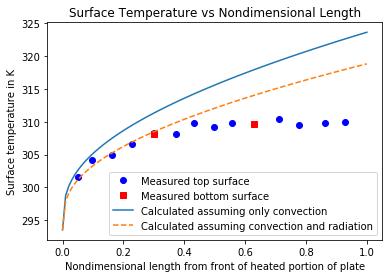

In [6]:
# 1a
x_thermloc_nond = (x_thermloc-zeta)/Lh
x_thermloc_nond_top = np.delete(x_thermloc_nond, [5,11])
x_thermloc_nond_bottom = x_thermloc_nond[[5,11]]
x_ther_nond = (x_ther-zeta)/Lh
plt.figure()
plt.plot(x_thermloc_nond_top, degCToK(Ts_top),'bo')
plt.plot(x_thermloc_nond_bottom, degCToK(Ts_bottom),'rs')
plt.plot(x_ther_nond, degCToK(Ts_top_ther_conv), '-')
plt.plot(x_ther_nond, degCToK(Ts_top_ther_convandrad), '--')
plt.legend(['Measured top surface', 'Measured bottom surface', 'Calculated assuming only convection', 'Calculated assuming convection and radiation'])
plt.title('Surface Temperature vs Nondimensional Length')
plt.xlabel('Nondimensional length from front of heated portion of plate')
plt.ylabel('Surface temperature in K')
plt.show()


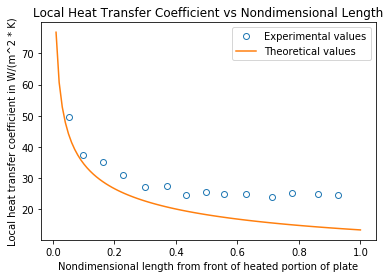

In [7]:
# 1b
plt.figure()
plt.plot(x_thermloc_nond_top, hx,'o', fillstyle='none')
plt.plot(x_ther_nond, hx_ther, '-')
plt.legend(['Experimental values', 'Theoretical values'])
plt.title('Local Heat Transfer Coefficient vs Nondimensional Length')
plt.xlabel('Nondimensional length from front of heated portion of plate')
plt.ylabel('Local heat transfer coefficient in W/(m^2 * K)')
plt.show()


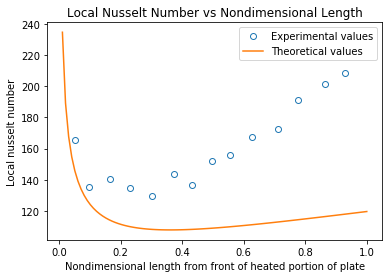

In [8]:
# 1c
plt.figure()
plt.plot(x_thermloc_nond_top, Nu_x,'o', fillstyle='none')
plt.plot(x_ther_nond, Nu_x_ther, '-')
plt.legend(['Experimental values', 'Theoretical values'])
plt.title('Local Nusselt Number vs Nondimensional Length')
plt.xlabel('Nondimensional length from front of heated portion of plate')
plt.ylabel('Local nusselt number')
plt.show()


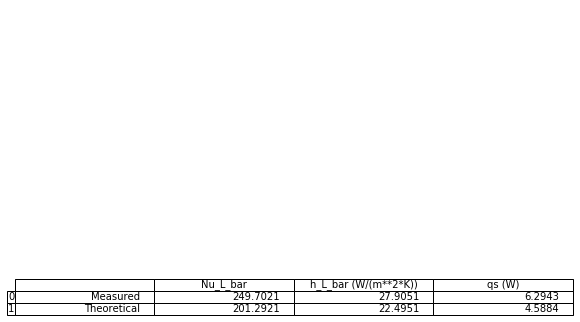

In [9]:
# 1d
table1d_data = {'': ['Measured', 'Theoretical'], 'Nu_L_bar':[Nu_L_bar,Nu_L_bar_ther], 'h_L_bar (W/(m**2*K))':[hL_bar,hL_bar_ther], 'qs (W)':[qs,qs_ther]} 
table1d = pd.DataFrame(table1d_data, columns=['', 'Nu_L_bar', 'h_L_bar (W/(m**2*K))', 'qs (W)'])
fig, ax = plt.subplots(1,1, figsize=(10,5)) 
ax.axis('off')
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
table1d = table1d.round(decimals=4)
table(ax, table1d) 
plt.show()


In [10]:
# 2a
Nu_x_pcterror = np.abs(((Nu_x-Nu_x_ther[x_ther_corresponding_idx])/(Nu_x_ther[x_ther_corresponding_idx]))*100)
print('Nu_x had a min percent difference between theoretical and experimental values of: {:.2f}% and a max of: {:.2f}%'.format(np.min(Nu_x_pcterror),np.max(Nu_x_pcterror)))

hx_pcterror = np.abs(((hx-hx_ther[x_ther_corresponding_idx])/(hx_ther[x_ther_corresponding_idx]))*100)
print('hx had a min percent difference between theoretical and experimental values of: {:.2f}% and a max of: {:.2f}%'.format(np.min(hx_pcterror),np.max(hx_pcterror)))

Ts_top_pcterror = np.abs(((Ts_top-Ts_top_ther_convandrad[x_ther_corresponding_idx])/(Ts_top_ther_convandrad[x_ther_corresponding_idx]))*100)
print('Ts_top had a min percent difference between theoretical and experimental values of: {:.2f}% and a max of: {:.2f}%'.format(np.min(Ts_top_pcterror),np.max(Ts_top_pcterror)))

Nu_x had a min percent difference between theoretical and experimental values of: 8.96% and a max of: 76.60%
hx had a min percent difference between theoretical and experimental values of: 8.91% and a max of: 77.24%
Ts_top had a min percent difference between theoretical and experimental values of: 0.54% and a max of: 17.92%


In [11]:
# 2b
hL_bar_pcterror = np.abs(((hL_bar-hL_bar_ther)/(hL_bar_ther))*100)
print('hL_bar had a percent difference between theoretical and experimental values of: {:.2f}%'.format(hL_bar_pcterror))

Nu_L_bar_pcterror = np.abs(((Nu_L_bar-Nu_L_bar_ther)/(Nu_L_bar_ther))*100)
print('Nu_L_bar had a percent difference between theoretical and experimental values of: {:.2f}%'.format(Nu_L_bar_pcterror))

hL_bar had a percent difference between theoretical and experimental values of: 24.05%
Nu_L_bar had a percent difference between theoretical and experimental values of: 24.05%


In [12]:
# 2c
print('The percentage of heat flux lost to the surroundings via radiation compared to net heat flux to the top surface by resistive heaters was: {:.2f}%'.format(((qs_primeprime_rad/qs_primeprime_conv)*100)))

The percentage of heat flux lost to the surroundings via radiation compared to net heat flux to the top surface by resistive heaters was: 15.98%


In [13]:
# 2d
print('The Reynolds number based on L for this experiment was: {:.2f}. This is much less than the critical Reynolds number for a flat plate of {:.2f} so the flow is expected to be laminar over the whole plate.'.format(Re_L, Re_c))

The Reynolds number based on L for this experiment was: 57933.37. This is much less than the critical Reynolds number for a flat plate of 500000.00 so the flow is expected to be laminar over the whole plate.
